In [1]:
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
# keras or tensorflow.keras? Long story short, one should use tensorflow.keras
# if there isn't any backward-compatibility concern

import numpy as np

In [2]:
dataset = np.loadtxt('files/pima-indians-diabetes.csv', delimiter=',', skiprows=1)
# 1st row is header
dataset

array([[  6.   , 148.   ,  72.   , ...,   0.627,  50.   ,   1.   ],
       [  1.   ,  85.   ,  66.   , ...,   0.351,  31.   ,   0.   ],
       [  8.   , 183.   ,  64.   , ...,   0.672,  32.   ,   1.   ],
       ...,
       [  5.   , 121.   ,  72.   , ...,   0.245,  30.   ,   0.   ],
       [  1.   , 126.   ,  60.   , ...,   0.349,  47.   ,   1.   ],
       [  1.   ,  93.   ,  70.   , ...,   0.315,  23.   ,   0.   ]])

In [3]:
X = dataset[:,0:8]
y = dataset[:,8]

In [4]:
X

array([[  6.   , 148.   ,  72.   , ...,  33.6  ,   0.627,  50.   ],
       [  1.   ,  85.   ,  66.   , ...,  26.6  ,   0.351,  31.   ],
       [  8.   , 183.   ,  64.   , ...,  23.3  ,   0.672,  32.   ],
       ...,
       [  5.   , 121.   ,  72.   , ...,  26.2  ,   0.245,  30.   ],
       [  1.   , 126.   ,  60.   , ...,  30.1  ,   0.349,  47.   ],
       [  1.   ,  93.   ,  70.   , ...,  30.4  ,   0.315,  23.   ]])

In [5]:
len(y)

768

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## The Sequential model and the Functional API
In Keras, there are two ways to create a model, the `Sequential model` and the `Functional API`.

* The `Sequential model` is a bit more intuitive in the sense that it considers a neural network as a stack of layers where each layer has exactly one input tensor and one output tensor, which is the usual way a neural work is presented;
* `Function API` is more flexible than `Sequential model` because it can handle models with non-linear topology, shared layers, and even multiple inputs or outputs.

Although `Sequential model` should be enough for this project, for the sake of accommodating possible future needs, `Functional API` approach is used.

In [22]:
visible = keras.layers.Input(shape=(8,))
# Input() is used to instantiate a Keras tensor.
hidden = layers.Dense(
    units=200,
    activation='relu',
    kernel_initializer='random_normal',
    bias_initializer='random_normal')(visible)
output = layers.Dense(units=1, activation='sigmoid')(hidden)
model = keras.Model(inputs=visible, outputs=output)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense_2 (Dense)             (None, 200)               1800      
                                                                 
 dense_3 (Dense)             (None, 1)                 201       
                                                                 
Total params: 2,001
Trainable params: 2,001
Non-trainable params: 0
_________________________________________________________________


### `get_weights`

`get_weights` returns the current weights of the layer, as NumPy arrays. The weights of a layer represent the state of the layer. For example, a Dense layer returns a list of two values: the kernel matrix and the bias vector. These can be used to set the weights of another Dense layer.

Note that:

* the number of weights per neuron depends on the number of connections it has to the previous layer.
* there is only one bias per neuron.

Therefore, in this particular model, we have $8 \times 200$ weights and $200$ biases. 

In [23]:
weights = model.layers[1].get_weights()[0]
bias =  model.layers[1].get_weights()[1]
print(len(weights), len(weights[0]))
print(len(bias))
print(weights[0][:20])
print(bias[:20])

8 200
200
[-0.02389144  0.01577247  0.05733165 -0.10927086 -0.00728742  0.03934352
 -0.03250908  0.07284249  0.05405402 -0.06419575  0.02319374 -0.01469582
  0.05386278  0.00711134  0.04565254 -0.01822776 -0.00557326  0.04537281
  0.02841549  0.04745246]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Note that the initial weights are not $0$ and initial biases are all $0$. This is controlled by `kernel_initializer` and `bias_initializer`. Since stochastic gradient descent is, well, stochastic, usually we should try to avoid initializing weights to $0$. This is sometimes referred to as "the need to break symmetry during training".

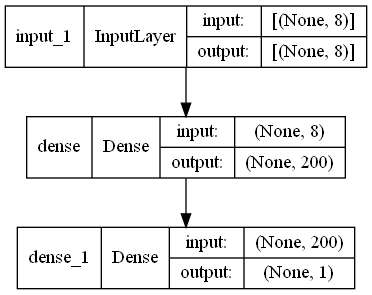

In [9]:
keras.utils.plot_model(model, show_shapes=True)

### Adam optimization algorithm

* The Adam optimization algorithm is an extension to stochastic gradient descent that has recently seen broader adoption for deep learning applications in computer vision and natural language processing. It was presented in a 2015 paper titled "Adam: A Method for Stochastic Optimization".

* Stochastic gradient descent maintains a single learning rate (termed alpha) for all weight updates and the learning rate does not change during training.

* Adam combines the advantages of two other extensions of stochastic gradient descent:
    * **Adaptive Gradient Algorithm** (AdaGrad) that maintains a *per-parameter learning rate* that improves performance on problems with sparse gradients (e.g. natural language and computer vision problems).
    * **Root Mean Square Propagation** (RMSProp) that also maintains *per-parameter learning rates* that are adapted based on the average of recent magnitudes of the gradients for the weight (i.e., how quickly it is changing). This means the algorithm does well on online and non-stationary problems (e.g. noisy).
    


* How does it compare with other algorithms?

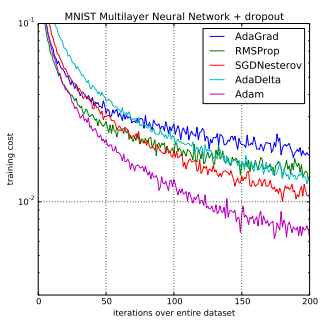

In [10]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### `epochs`

* The number of epochs is a hyperparameter that defines the number times that the learning algorithm will work through the *entire* training dataset.

* One epoch means that each sample in the training dataset has had an opportunity to update the internal model parameters. An epoch is comprised of one or more batches.

* The number of epochs equals the number of iterations if the batch size is the entire training dataset.

* The number of epochs is traditionally large, often hundreds or thousands, allowing the learning algorithm to run until the error from the model has been sufficiently minimized.

* Line plots with epochs along the x-axis as time and the model’s error or ability on the y-axis are typical. These plots are also known as learning curves

### `batch_size`

In each iteration of the stochastic gradient descent, the algorithm randomly picks `batch_size` number of samples from the training set to calculate an approximate gradient to the exact gradient.

In [11]:
history = model.fit(
    x=X_train, y=y_train,
    epochs=200,
    batch_size=100,
    verbose=1,
    validation_data=(X_test, y_test)
)

Epoch 1/200
6/6 [==============================] - 1s 47ms/step - loss: 18.4658 - accuracy: 0.6459 - val_loss: 10.6391 - val_accuracy: 0.6614
Epoch 2/200
6/6 [==============================] - 0s 8ms/step - loss: 7.6767 - accuracy: 0.5895 - val_loss: 3.9582 - val_accuracy: 0.3701
Epoch 3/200
6/6 [==============================] - 0s 8ms/step - loss: 4.5026 - accuracy: 0.3891 - val_loss: 3.7221 - val_accuracy: 0.3386
Epoch 4/200
6/6 [==============================] - 0s 9ms/step - loss: 2.2893 - accuracy: 0.4280 - val_loss: 1.9223 - val_accuracy: 0.6575
Epoch 5/200
6/6 [==============================] - 0s 8ms/step - loss: 2.0790 - accuracy: 0.6498 - val_loss: 1.6461 - val_accuracy: 0.6457
Epoch 6/200
6/6 [==============================] - 0s 8ms/step - loss: 1.7886 - accuracy: 0.5525 - val_loss: 1.7565 - val_accuracy: 0.4803
Epoch 7/200
6/6 [==============================] - 0s 8ms/step - loss: 1.1694 - accuracy: 0.5564 - val_loss: 1.1167 - val_accuracy: 0.5748
Epoch 8/200
6/6 [=======

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


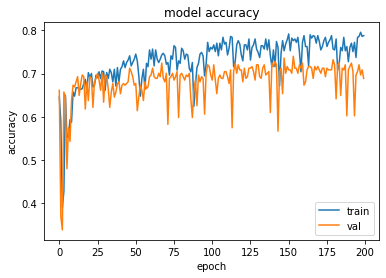

In [12]:
print(history.history.keys())

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')

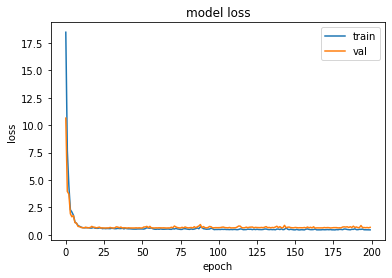

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

In [14]:
print(model.layers[1].get_weights()[0][0][:20])

[ 0.06700224 -0.1322436  -0.02196113 -0.00956977  0.05318196 -0.06338283
  0.04145793 -0.11132008 -0.16959323 -0.02305274  0.13499713  0.05709839
  0.19416204 -0.02227015  0.14258422 -0.13321175  0.13718268 -0.11461449
  0.08735527 -0.08384894]


Confusion matrix:
[[242  90]
 [ 23 159]]


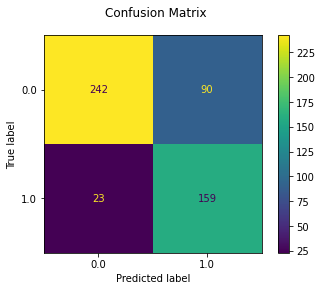

In [15]:
y_pred = (model.predict(X_train) > 0.5).astype(int)
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_true=y_train, y_pred=y_pred)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

Confusion matrix:
[[117  51]
 [ 28  58]]
Balanced accuracy: 68.54%


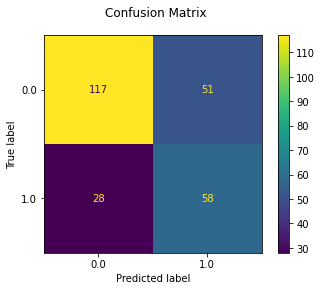

In [16]:
y_pred = (model.predict(X_test) > 0.5).astype(int)
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_pred)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
tn, fp, fn, tp = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred).ravel()
accuracy = (tn + tp) / (tn + fp + fn + tp)
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
tnr = tn / (tn + fp)
balanced_accuracy = (tpr + tnr) / 2
print(f"Balanced accuracy: {balanced_accuracy*100:.2f}%")

In [17]:
from sklearn.neural_network import MLPClassifier as mlpc

clf = mlpc(hidden_layer_sizes=(100, ))
# Keras allows users to specify the activation function of the output layer.
# However, you canNOT set this parameter in scikit-learn, though you can check
# the automatically selected activation function via the out_activation_ attribute of
# a model.
# https://stackoverflow.com/questions/55337843/what-kind-of-activation-is-used-by-scikitlearns-mlpclasssifier-in-output-layer
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

Confusion matrix:
[[136  32]
 [ 34  52]]


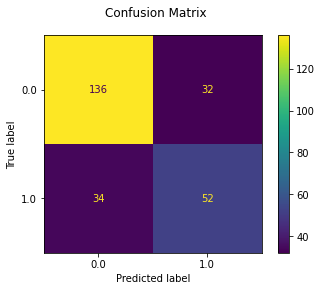

In [18]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

In [19]:
tn, fp, fn, tp = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred).ravel()
accuracy = (tn + tp) / (tn + fp + fn + tp)
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
tnr = tn / (tn + fp)
balanced_accuracy = (tpr + tnr) / 2
print(f"Balanced accuracy: {balanced_accuracy*100:.2f}%")

Balanced accuracy: 70.71%
